# ARIMA / SARIMA
## 1. Formulation mathématique
### 1.1 ARIMA
---

### 1.2 SARIMA
---


## 2. Exemple en Python
### 2.1 Import des librairies
---

In [24]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import sys
import functions as fct
from matplotlib.pylab import rcParams
from scipy.stats import boxcox
import pickle

from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import seaborn as sns

sns.set_style("darkgrid") # Style des graphes

Fonctions personnalisées :

In [25]:
def adfuller_test(ts, window = 12): 
    """
    Test de Dicker-Fuller augmenté (test d'hypothèses de non-stationnarité)
    """
    
    adf = adfuller(ts, autolag='AIC')
    
    print('ADF Statistic: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))
    print("##################################")  
    print('Critical Values:')
    
    for key, ts in adf[4].items():
         print('{}: {}'.format(key, round(ts,3)))
    print("##################################")
    
    if adf[0] > adf[4]["5%"]:
        print("ADF > Critical Values")
        print ("Failed to reject null hypothesis, time series is non-stationary.")
    else:
        print("ADF < Critical Values")
        print ("Reject null hypothesis, time series is stationary.")

def InverseDifferenciation(forecast_diff, original_series, s, d=1, D=1):
    """
    Reconstruit les prévisions SARIMA à partir des valeurs différenciées.

    Input:
        [pd.Series] forecast_diff : prévisions dans l'espace différencié.
        [pd.Series] original_series : série d'origine avant modélisation.
        [int] s : saisonnalité (ex. 12 pour des données mensuelles).
        [int] d : ordre de différenciation simple.
        [int] D : ordre de différenciation saisonnière.

    Output:
        pd.Series: Prévisions reconstruites dans l’échelle d’origine.
    """
    if D > 0:
        last_seasonal_vals = list(original_series[-s:].values)
    else:
        last_seasonal_vals = [0] * s

    if d > 0:
        last_val_d = original_series.iloc[-1]
    else:
        last_val_d = 0

    reconstructed = []
    for i in range(len(forecast_diff)):
        val = forecast_diff.iloc[i]

        if D > 0:
            seasonal_lag = i % s
            val += last_seasonal_vals[seasonal_lag]

        if d > 0:
            if i == 0:
                val += last_val_d
            else:
                val += reconstructed[-1]

        reconstructed.append(val)

    start_date = original_series.index[-1] + pd.offsets.MonthEnd(1)
    return pd.Series(reconstructed, index=pd.date_range(start=start_date, periods=len(forecast_diff), freq='ME'))


def plot_acf_pacf(series, lags=40, figsize=(10, 5)):
    """
    Affiche les fonctions d'autocorrélation (ACF) et d'autocorrélation partielle (PACF)

    Input:
        [pd.Series] series : série à analyser.

    Output:
        plot des fonctions ACF et PACF
    """
    
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    plot_acf(series, ax=ax[0], lags=lags)
    plot_pacf(series, ax=ax[1], lags=lags)
    ax[0].set_title("ACF")
    ax[1].set_title("PACF")
    plt.tight_layout()
    plt.show()

### 2.2 Import du dataset
---
Le dataset est issu de Kaggle et représente la production électrique d'une installation au cours du temps

In [26]:
df = pd.read_csv(
    'src/Electric_Production.csv',
    index_col=0,
    parse_dates=[0],
    date_format="%m/%d/%Y",
    decimal=','
)

df['IPG2211A2N'] = pd.to_numeric(df['IPG2211A2N'], errors='coerce') # Transformation des données en valeur numériques (float)
df = df.dropna()

df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


### 2.3 Tendance et saisonnalité
---
La tendance correspond à la stationnarité ou non de la série. En effet, si la tendance (moyenne mobile qui lisse la série) est constante, alors la série est stationnaire. Si la tendance augmente ou diminue, alors le signal est non-stationnaire.

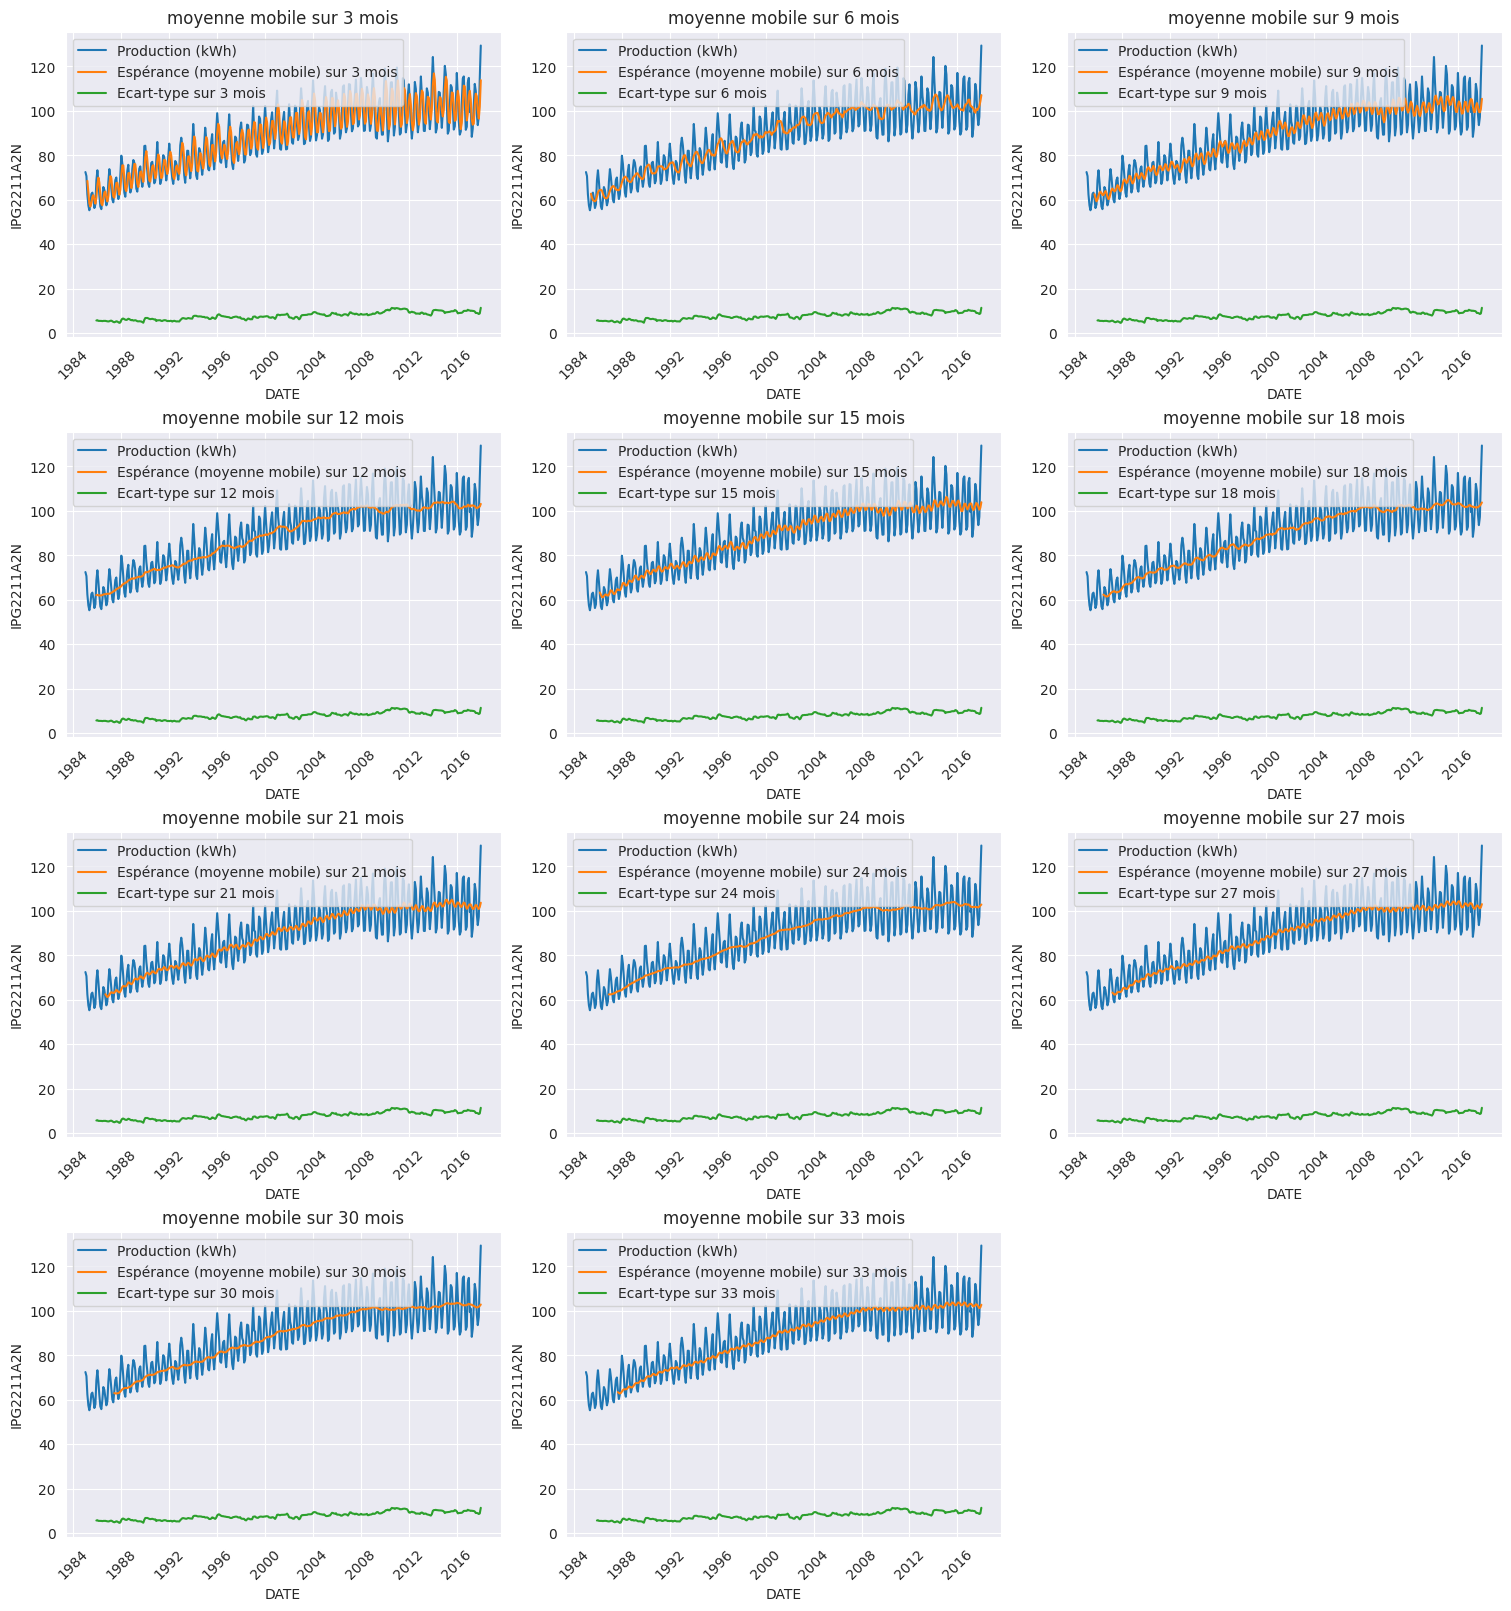

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [27]:
seasonnality = range(3,39,3) # Moyennes mobiles sur 3 à 36 mois par pas de 3 mois pour la détection de saisonnalité
cols = 3
rows = math.ceil(len(seasonnality) / cols) 

fig, axes = plt.subplots(
    rows,
    cols,
    figsize = (5*cols, 4*rows),
    constrained_layout=True
)
axes = axes.flatten()

for i, window in enumerate(range(3,36,3)):
    df['rolling_mean'] = df['IPG2211A2N'].rolling(window=window).mean() # Moyenne locale, lissage du signal sur 12 mois
    df['rolling_std'] = df['IPG2211A2N'].rolling(window=12).std() # std (Standart Deviation) sur 12 mois
    
    plt.figure(figsize = (12,6))
    sns.lineplot(
        df,
        x = df.index,
        y = df["IPG2211A2N"],
        label="Production (kWh)",
        ax=axes[i]
    )
    
    sns.lineplot(
        df,
        x = df.index,
        y = "rolling_mean",
        label=f"Espérance (moyenne mobile) sur {window} mois",
        ax=axes[i]
    )
    
    sns.lineplot(
        df,
        x = df.index,
        y = "rolling_std",
        label=f"Ecart-type sur {window} mois",
        ax=axes[i]
    )

    axes[i].set_title(f"moyenne mobile sur {window} mois")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)): # Retire les axes inutiles
    fig.delaxes(axes[j])

plt.show()

Comme on peut le voir sur les graphiques, la série est non-stationnaire, i.e. l'espérance du sigal est non constante (pas d'invariance par translation temporelle). On aurait pu le déterminer aussi statistiquement à l'aide d'un test d'hypothèses nommé *Augmented Dicker-Fuller test*. 

Pourquoi vérifier sa stationnarité ? Si le signal est non stationnaire, la fonction d'autocorrélation ne dépend plus uniquement du décalage temporel entre la fonction et elle-même mais aussi du temps, ce qui complique fortement l'étude. On cherche donc à éliminer la tendance pour rendre le signal stationnaire. De plus, si la série est non-stationnaire, il va falloir la différencier pour la rendre stationnaire, on a donc, à ce stade de l'étude, que $d \neq 0$.

De plus, on voit que la tendance pour 6, 12, 18 et 24 semble relativement lisse, ce qui laisse à penser que $s=6$ ou $s=12$ mois.

In [28]:
adfuller_test(df["IPG2211A2N"], window = 12)

ADF Statistic: -2.257
p-value: 0.186
##################################
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
##################################
ADF > Critical Values
Failed to reject null hypothesis, time series is non-stationary.


Le test de Dickey-Fuller augmenté confirme la non-stationnarité du signal, il faut donc rendre la série non staionnaire pour régler les modèles qui supposent une série stationnaire.

### 2.4 Réglage des modèles
---
#### 2.4.1 ARIMA(p,d,q)

#### d comme différenciation (I)
Le modèle ARIMA suppose que la série est stationnaire, c'est pourquoi le test de Dicker-Fuller augmenté (ADF) a été formulé plus tôt dans l'étude. Dans le cas ou la série ne serait pas stationnaire, il faut la rendre stationnaire en utilisant une méthode appelée la **différenciation**. On a pour la série $Y$, des éléments $y$ à l'instant $t$, notés $y_{t}$. La différenciation consite à retrancher l'élément à l'instant $t$ l'élément à l'instant $t-1$, i.e. $y_{t}' = y_{t} - y_{t-1}$. On répète $d$ fois ce processus afin de rendre la série stationnaire. Par exemple, si l'on retranche à l'instant $t$ l'instant $t-1$ une fois et que la série devient stationnaire (ce qui sera le cas dans l'exeple prochain), alors $d = 1$.

#### p (AR)

Pour déterminer $p$, on utilise la fonction d'autocorrélation (ACF). D'après le graphique de cette fonction, on peut trouver le premier lag ou la fonction diminue fortement, par exemple, si ACF(1) = 1, ACF(2) = 0.96, ACF(3) = -0.5, la fonction décroit fortement au lag 2, soit $p=2$.

#### q (MA)

Pour déterminer $q$, on utilise la fonction d'autocorrélation partiele (PACF). De même pour $q$, PACF(1) = 0.95, PACF(2) = 0.1, PACF(3) = -0.64, la fonction décroit fortement au lag 1, soit $q=1$.

#### 2.4.2 SARIMA(p,d,q)(P,D,Q)(S)

#### D

#### P


#### Q


#### S

### 2.5 Supression de la non-stationnairité (différenciation)
---
Etant donné que le signal n'est pas stationnaire, on décide de retirer la tendance non-stationnaire. Pour retirer la non-stationnarité du signal, on retranche la transformation logarithmique du signal par sa moyenne mobile, tel que pour un signal $s_{t}$ non-stationnaire, on a sont signal stationnaire $s_{s}$ tel que :

$$
s_{s} = \log{(s_{ns})} - ma(\log{(s_{ns}}))
$$

avec $ma(s)$ la moyenne mobile du signal $s$
#### 2.5.1 Transformation logarithmique

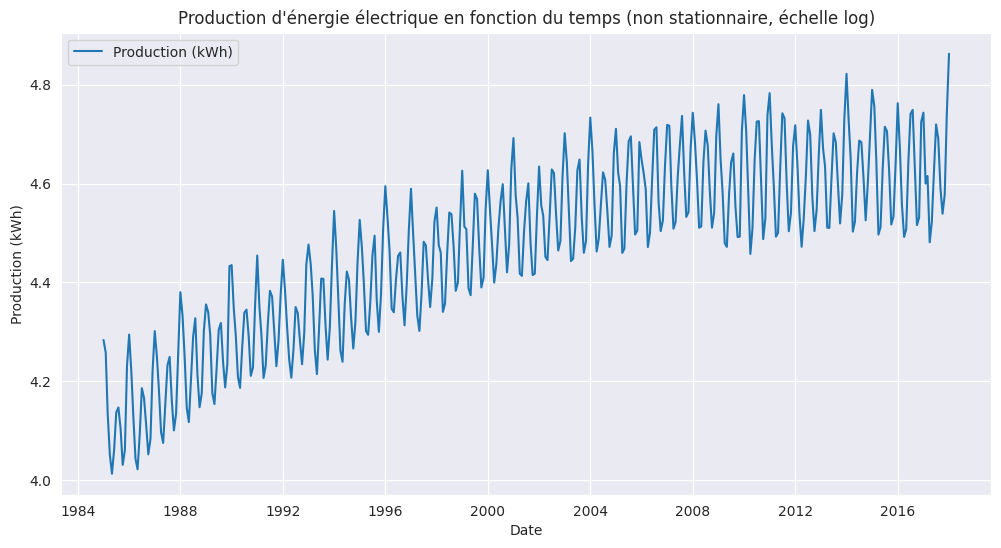

In [29]:
df['IPG2211A2N log'] = boxcox(df['IPG2211A2N'], lmbda=0.0) # Transformation logarithmique

# Affichage
plt.figure(figsize = (12,6))
sns.lineplot(
    df,
    x = df.index,
    y = [float(_) for _ in df["IPG2211A2N log"]],
    label="Production (kWh)"
)

plt.xlabel("Date")
plt.ylabel("Production (kWh)")
plt.title("Production d'énergie électrique en fonction du temps (non stationnaire, échelle log)")
plt.legend()
plt.show()

#### 2.5.2 Stationnarisation

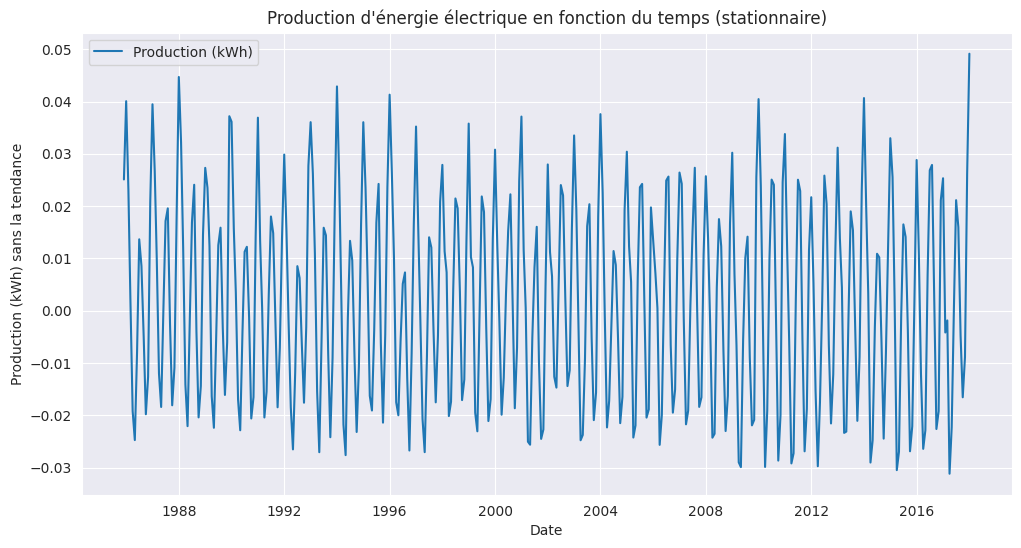

In [30]:
df['IPG2211A2N log'] = boxcox(df['IPG2211A2N log'], lmbda=0.0) # On reprend la transformation logarithmique
moving_avg = df['IPG2211A2N log'].rolling(window=12).mean() # Moyenne mobile sur s = 12 mois

df['IPG2211A2N stationnaire'] = df['IPG2211A2N log'] - moving_avg # Signal stationnaire

# Affichage
plt.figure(figsize = (12,6))
sns.lineplot(
    df,
    x = df.index,
    y = [float(_) for _ in df['IPG2211A2N stationnaire']],
    label="Production (kWh)"
)

plt.xlabel("Date")
plt.ylabel("Production (kWh) sans la tendance")
plt.title("Production d'énergie électrique en fonction du temps (stationnaire)")
plt.legend()
plt.show()

#### 2.5.3 Re-vérification de la stationnarité
On teste une deuxième fois si le signal est staionnaire ou non :

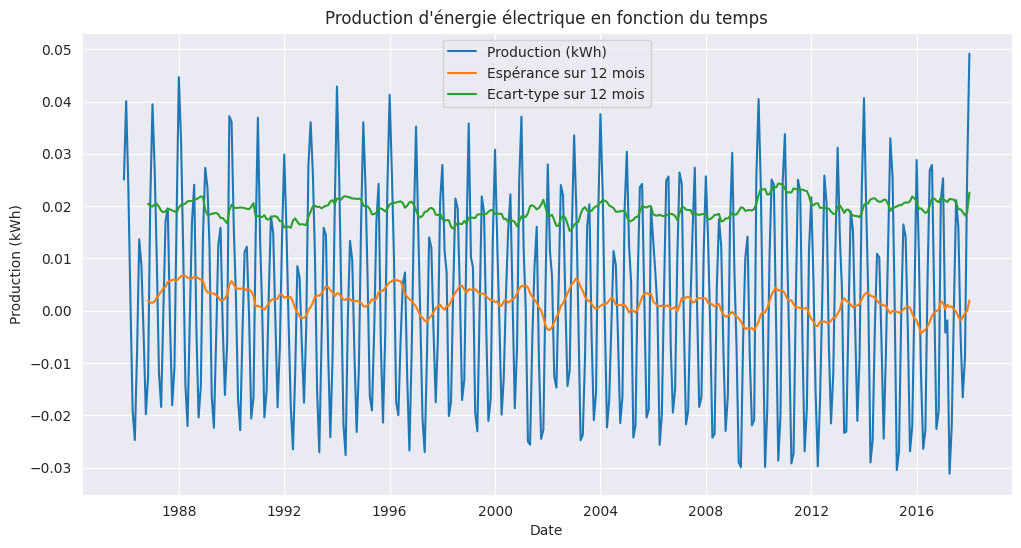

In [31]:
window = 12
df['rolling_mean'] = df['IPG2211A2N stationnaire'].rolling(window=window).mean() # Moyenne locale, lissage du signal sur 12 mois
df['rolling_std'] = df['IPG2211A2N stationnaire'].rolling(window=12).std() # std (Standart Deviation) sur 12 mois

plt.figure(figsize = (12,6))
sns.lineplot(
    df,
    x = df.index,
    y = df['IPG2211A2N stationnaire'],
    label="Production (kWh)"
)

sns.lineplot(
    df,
    x = df.index,
    y = "rolling_mean",
    label=f"Espérance sur {window} mois"
)

sns.lineplot(
    df,
    x = df.index,
    y = "rolling_std",
    label=f"Ecart-type sur {window} mois"
)

plt.xlabel("Date")
plt.ylabel("Production (kWh)")
plt.title("Production d'énergie électrique en fonction du temps")
plt.legend()
plt.show()

Test de Dicker-Tuller augmenté :

In [32]:
df.dropna(inplace=True) # Nettoyage des données
adfuller_test(df['IPG2211A2N stationnaire'], window = 12)

ADF Statistic: -5.409
p-value: 0.0
##################################
Critical Values:
1%: -3.449
5%: -2.87
10%: -2.571
##################################
ADF < Critical Values
Reject null hypothesis, time series is stationary.


Le test de Dicker-Fuller indique que la série est stationnaire après une différenciation, donc $d=1$

### 2.6 Décomposition
---

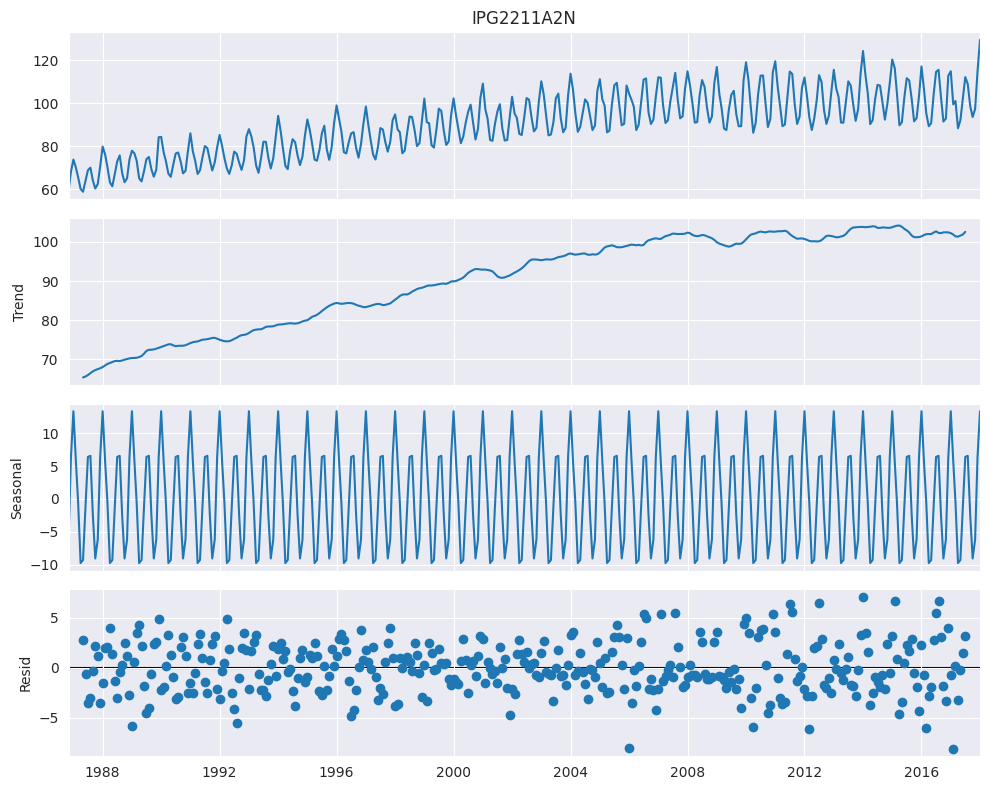

In [33]:
rcParams['figure.figsize']=10,8
df_seasonal_decompose = seasonal_decompose(df["IPG2211A2N"], model='duplicative')
df_seasonal_decompose.plot()
plt.show()

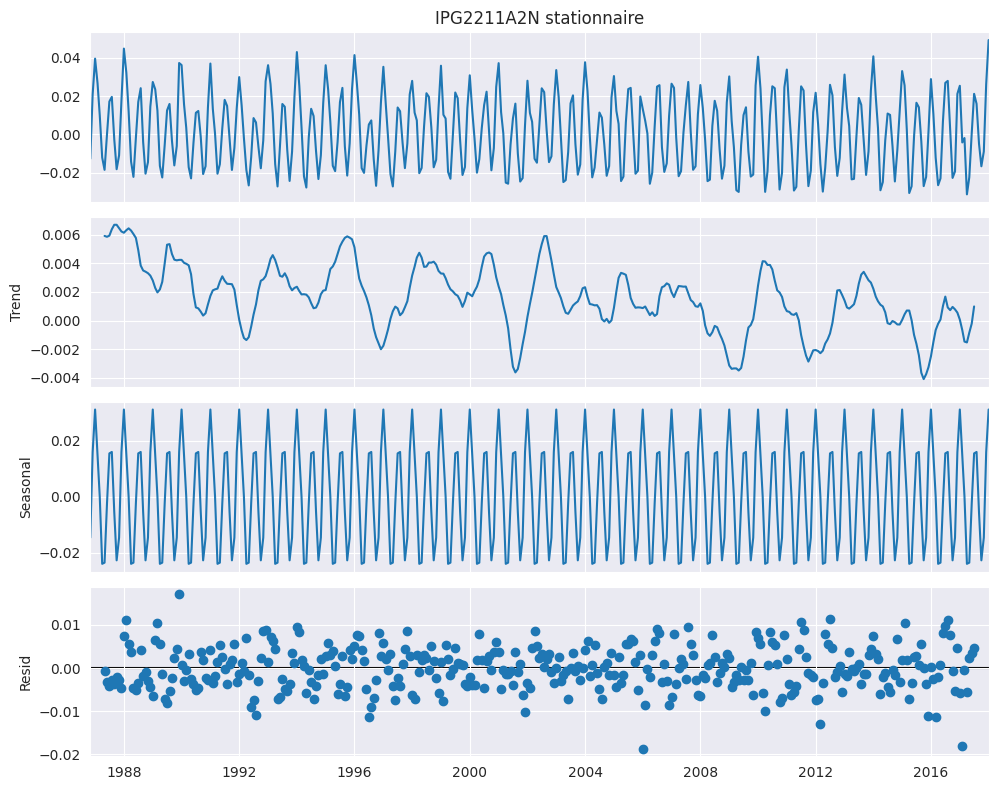

In [34]:
rcParams['figure.figsize']=10,8
df_seasonal_decompose = seasonal_decompose(df['IPG2211A2N stationnaire'], model='duplicative')
df_seasonal_decompose.plot()
plt.show()

### 2.7 Analyse de la série temporelle obtenue
---
Les analyses suivantes permettent *in fine* de régler l'ordre du modèle. Pour plus d'informations, voir la synthèse de l'analyse.

#### 2.7.1 Autocorrélation
L'autocorrélation est très utilsée dans l'étude des séries temporelles. En effet, cela permet de détecter la saisonnalité du signal. Le lag qui a le plus grand pic donne la saisonnalité tandis que le 1er lag (première valeur) donne le taux de dépendance avec la valeur précédente : plus la valeur de l'autocorrélation est proche de 1 au lag 1, plus les valeurs sont dépendantes de leurs valeur précédentes.

#### 2.7.2 Autocorrélation partielle

#### 2.7.3 ACF et PACF sur la série non-staionnaire

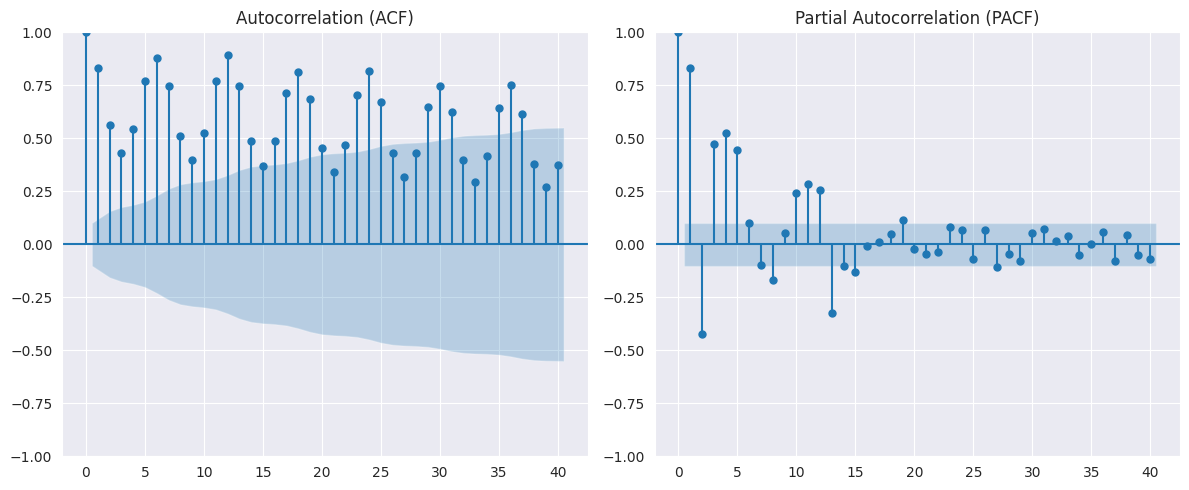

In [35]:
series = df['IPG2211A2N'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(series, lags=40, ax=axes[0])
axes[0].set_title("Autocorrelation (ACF)")

plot_pacf(series, lags=40, ax=axes[1])
axes[1].set_title("Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()

Ici, l'ACF décroit vers 0, ce qui indique, comme évoqué précédement, que la série n'est pas stationnaire (bon moyen de vérification des tests et hypothèses posées au départ par ailleurs). L'ACF ne donnera rien sur les valeurs de $p$ et de $q$ tant que la série ne sera pas différenciée au moins 1 fois (encore une fois on a vu précédement que $d \neq 0)$. En revanche, le PACF indique une coupure nette au lag 1 puis une autre au lag 2, ce qui indique que $p = 1$ ou $p = 2$ .

#### 2.7.4 ACF et PACF sur la série stationnaire

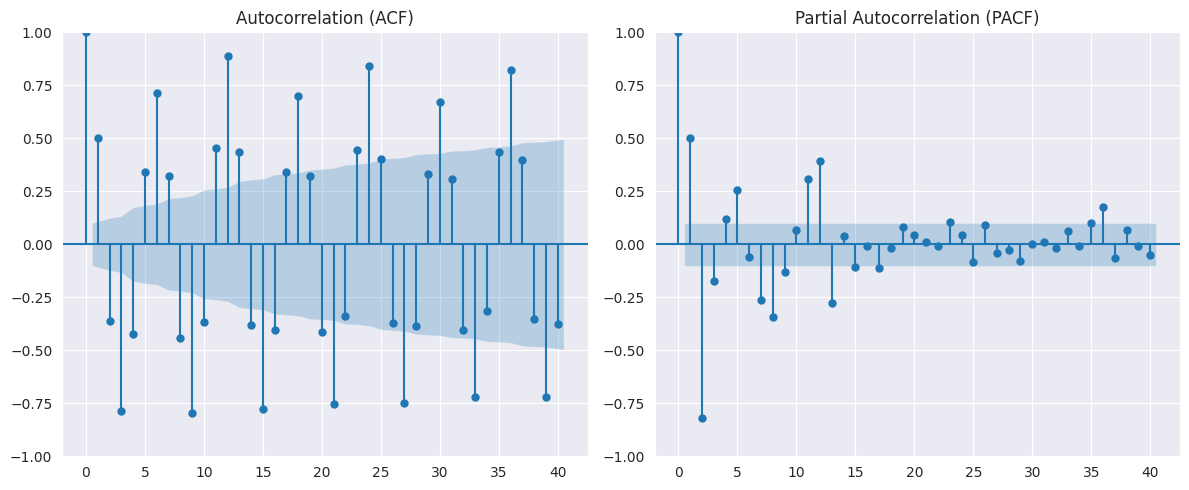

In [36]:
series = df['IPG2211A2N stationnaire'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(series, lags=40, ax=axes[0])
axes[0].set_title("Autocorrelation (ACF)")

plot_pacf(series, lags=40, ax=axes[1])
axes[1].set_title("Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()

Ici, d'après l'ACF, il y a une grosse coupure au lag 1 puis au lag 2. Encore une fois, $q = 1$ ou $q = 2$. Comme pour la série non-staionnaire, le PACF diminue très fortement à partir du lag 1 et 2, donc $q=1$ ou $q=2$. Le motif se répète tout les 6 et 12 lags, ce qui suppose que $s = 6$ ou $s = 12$ (come évoqué plus haut).

En conclusion, les triplets (1,1,1), (2,1,1), (1,1,2), (2,1,2) sont à tester pour ARIMA et les sextuplets (1,1,1)(1,1,1)(12), (2,1,1)(2,1,1)(12), (1,1,2)(1,1,2)(12), (2,1,2)(2,1,2)(12), (1,1,1)(1,1,1)(6), (2,1,1)(2,1,1)(6), (1,1,2)(1,1,2)(6), (2,1,2)(2,1,2)(6) sont à tester pour SARIMA. Evidement les tester à la main est une tâche assez fastidieuse, pour cela on utilise un réglage automatique.

### 2.8 Auto réglage des modèles
---
#### 2.8.1 Auto réglage du modèle ARIMA

#### 2.8.2 Auto réglage du modèle SARIMA

### 2.9 Prédictions sur les modèles
---
### 2.9.1 Séparation des données de test et de train
Ici, on utilise la commande `shuffle` qui permet de garder l'ordre chronologique de la série temporelle, afin d'aviter de faire un tirage aléatoire lors du séparage entre les données de trian et de test. 

In [37]:
df.index = pd.to_datetime(df.index)
df = df.asfreq('MS')  # 'M' pour des données mensuelles

print(df.shape)

X = df["IPG2211A2N"]
y = df.index

train, test = train_test_split(X, test_size=0.1, shuffle=False) # Séparation train et test

(375, 5)


### 2.9.2 Entraînement du modèle ARIMA
Une fois le modèle réglé, on l'entraîne :

In [38]:
model = ARIMA(train, 
              order=(2, 0, 1))  # Ajuster les ordres selon les ACF/PACF
result = model.fit()

result.summary()

/home/alexis/VSCode/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             IPG2211A2N   No. Observations:                  337
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1081.210
Date:                Mon, 05 May 2025   AIC                           2172.420
Time:                        00:08:32   BIC                           2191.521
Sample:                    11-01-1986   HQIC                          2180.033
                         - 11-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.8505      1.751     50.740      0.000      85.418      92.283
ar.L1          1.0064      0.089     11.303      0.000       0.832       1.181
ar.L2         -0.2793      0.089     -3.141      0.002      -0.454      -0.105
ma.L1          0.4682      0.077      6.085      0.000       0.317       0.619
sigma2        35.5943      2.825     12.598      0.000      30.056      41.132
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):                 1.93
Prob(Q):                              0.44   Prob(JB):                         0.38
Heteroskedasticity (H):               1.91   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 2.9.3 Prédiction sur les données test (ARIMA)
Une fois le modèle réglé, on souhaite prédire les valeurs futures. Avant cela, on teste les valeurs estimées par le modèle sur des données conues pour les comparer a posteriori afin d'évaluer les performances du modèle.

In [39]:
forecast_result = result.get_forecast(steps=len(test))
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

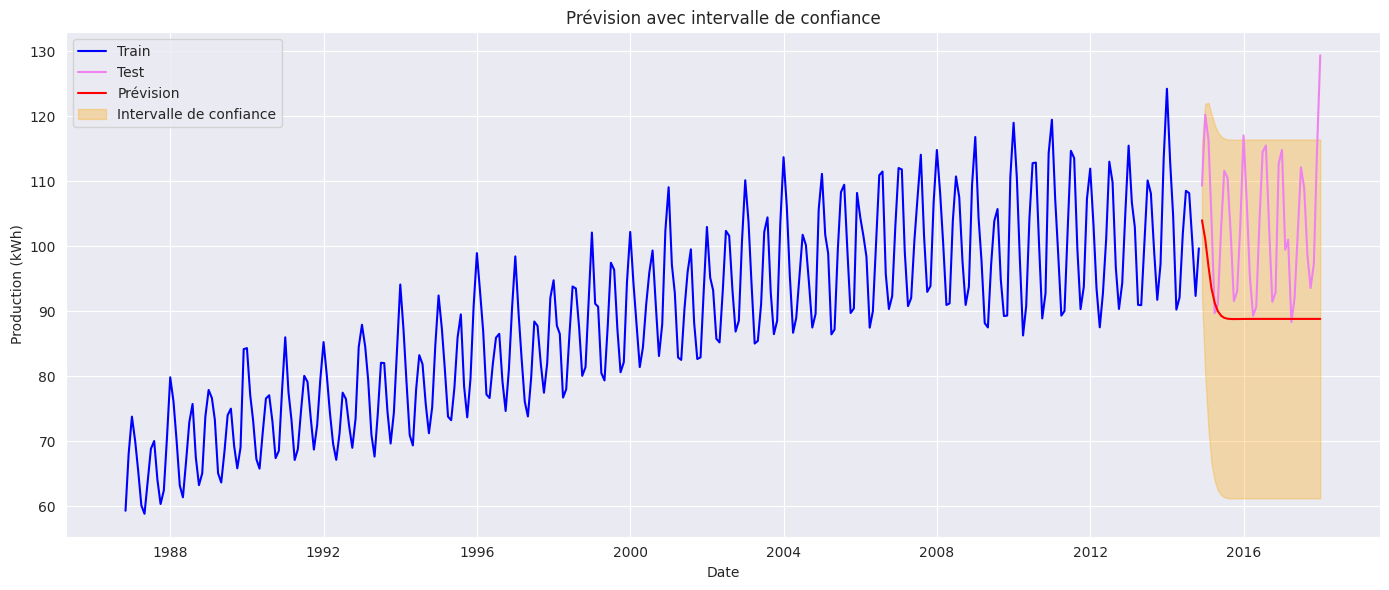

In [40]:
forecast_index = test.index
pred_df = pd.DataFrame({
    "date": forecast_index,
    "forecast": forecast,
    "lower": conf_int.iloc[:, 0],
    "upper": conf_int.iloc[:, 1]
}).set_index("date")

train_df = train.to_frame(name='value')
test_df = test.to_frame(name='value')

# Affichage
plt.figure(figsize=(14, 6))

sns.lineplot(data=train_df, x=train_df.index, y='value', label="Train", color="blue")
sns.lineplot(data=test_df, x=test_df.index, y='value', label="Test", color="violet")
sns.lineplot(data=pred_df, x=pred_df.index, y='forecast', label="Prévision", color="red")
plt.fill_between(
    pred_df.index,
    pred_df["lower"],
    pred_df["upper"],
    color="orange",
    alpha=0.3, 
    label="Intervalle de confiance")

plt.title("Prévision avec intervalle de confiance")
plt.xlabel("Date")
plt.ylabel("Production (kWh)")
plt.legend()
plt.tight_layout()
plt.show()

### 2.9.2 Entraînement du modèle SARIMA

In [41]:
model = SARIMAX(train, 
                order=(1, 1, 2), 
                seasonal_order=(1, 1, 2, 12))
result = model.fit(maxiter=10000)

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         IPG2211A2N   No. Observations:                  337
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -728.684
Date:                            Mon, 05 May 2025   AIC                           1471.368
Time:                                    00:08:35   BIC                           1497.833
Sample:                                11-01-1986   HQIC                          1481.931
                                     - 11-01-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3903      0.107      3.655      0.000       0.181       0.600
ma.L1         -0.7622      0.111     -6.858      0.000      -0.980      -0.544
ma.L2         -0.1755      0.098     -1.792      0.073      -0.367       0.016
ar.S.L12      -0.4610      0.357     -1.290      0.197      -1.162       0.240
ma.S.L12      -0.1927      0.347     -0.555      0.579      -0.873       0.487
ma.S.L24      -0.4426      0.241     -1.833      0.067      -0.916       0.031
sigma2         5.0720      0.362     14.012      0.000       4.363       5.781
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                18.21
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               2.63   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 2.9.3 Prédiction sur les données test (SARIMA)

In [42]:
forecast_result = result.get_forecast(steps=len(test))
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

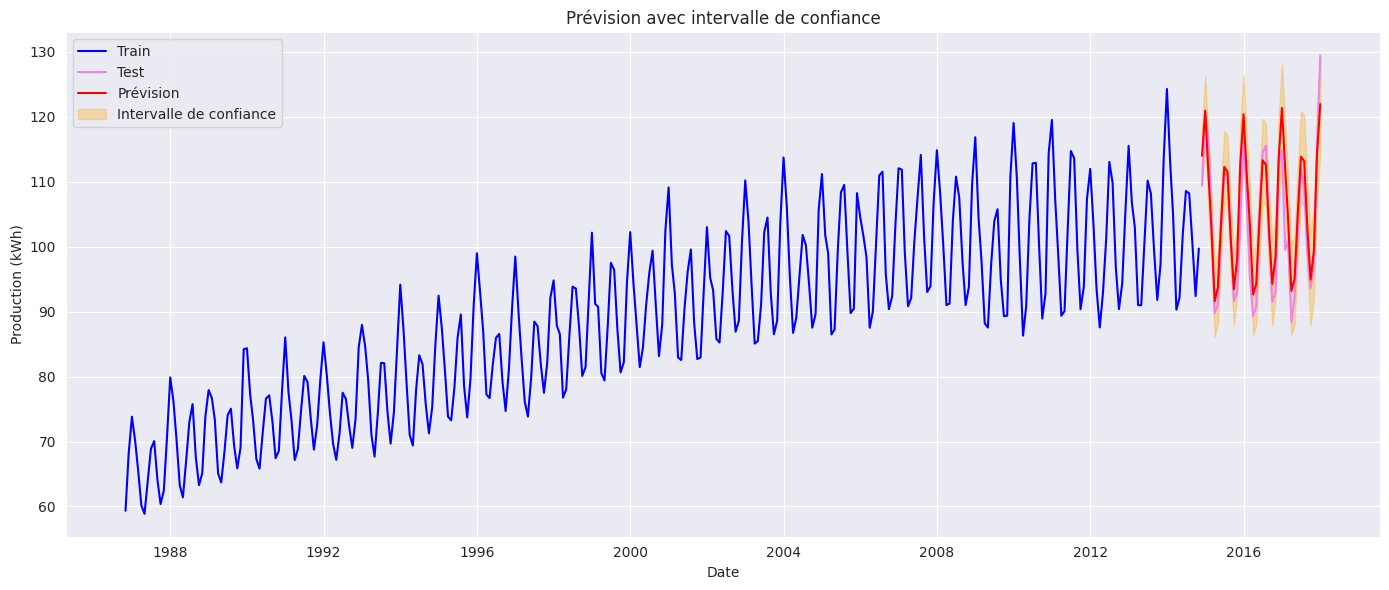

In [43]:
forecast_index = test.index
pred_df = pd.DataFrame({
    "date": forecast_index,
    "forecast": forecast,
    "lower": conf_int.iloc[:, 0],
    "upper": conf_int.iloc[:, 1]
}).set_index("date")

train_df = train.to_frame(name='value')
test_df = test.to_frame(name='value')

# Affichage
plt.figure(figsize=(14, 6))

sns.lineplot(data=train_df, x=train_df.index, y='value', label="Train", color="blue")
sns.lineplot(data=test_df, x=test_df.index, y='value', label="Test", color="violet")
sns.lineplot(data=pred_df, x=pred_df.index, y='forecast', label="Prévision", color="red")
plt.fill_between(
    pred_df.index,
    pred_df["lower"],
    pred_df["upper"],
    color="orange",
    alpha=0.3,
    label="Intervalle de confiance")

plt.title("Prévision avec intervalle de confiance")
plt.xlabel("Date")
plt.ylabel("Production (kWh)")
plt.legend()
plt.tight_layout()
plt.show()

Au vu des prévisions, le modèle SARIMA apparaît comme étant beaucoup plus performant. Cela est du au fait que le modèle ARIMA classique ne prend pas en compte la saisonnalité dans ses prévisions.

# 2.10 Prédictions futures
---
Une fois que le modèle est validé sur les données de test, on peut prédire des valeurs futures, donc inconnues par le modèle et le data-scientist. On reprend le modèle entraîné :

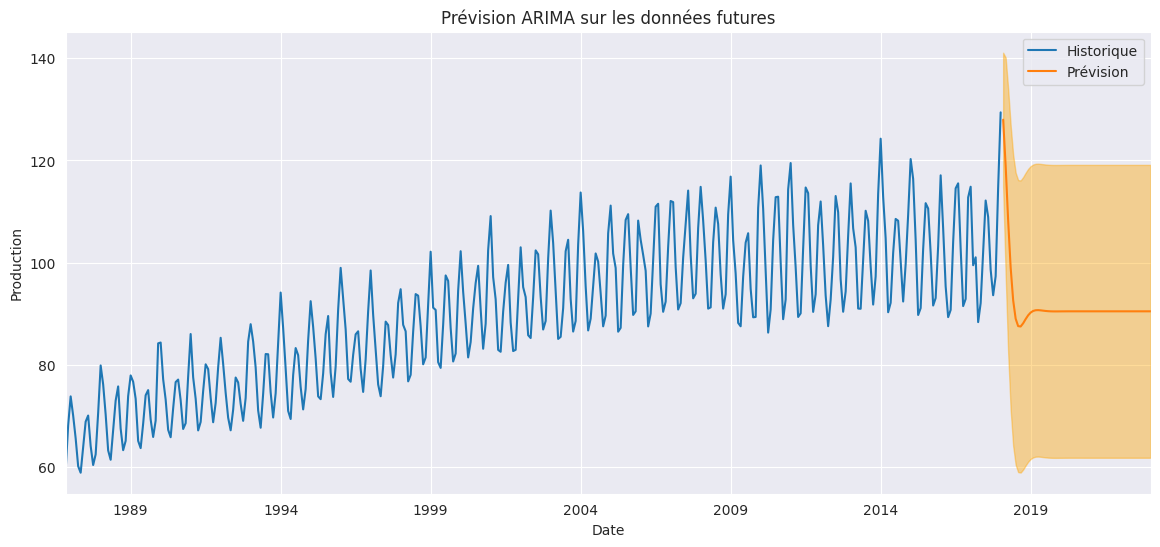

In [44]:
model = ARIMA(df["IPG2211A2N"], 
              order=(2, 0, 0))  # Ajuster les ordres selon les ACF/PACF
result = model.fit()

n_steps = 5*12 # Prédiction sur 5 ans dans le futur
forecast = result.get_forecast(steps=n_steps)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Visualisation
plt.figure(figsize=(14, 6))
df['IPG2211A2N'].plot(label='Historique')

# Afficher la prévision
mean_forecast.plot(label='Prévision')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='orange',
                 alpha=0.4
                )

plt.legend()
plt.title('Prévision ARIMA sur les données futures')
plt.xlabel('Date')
plt.ylabel('Production')
plt.show()

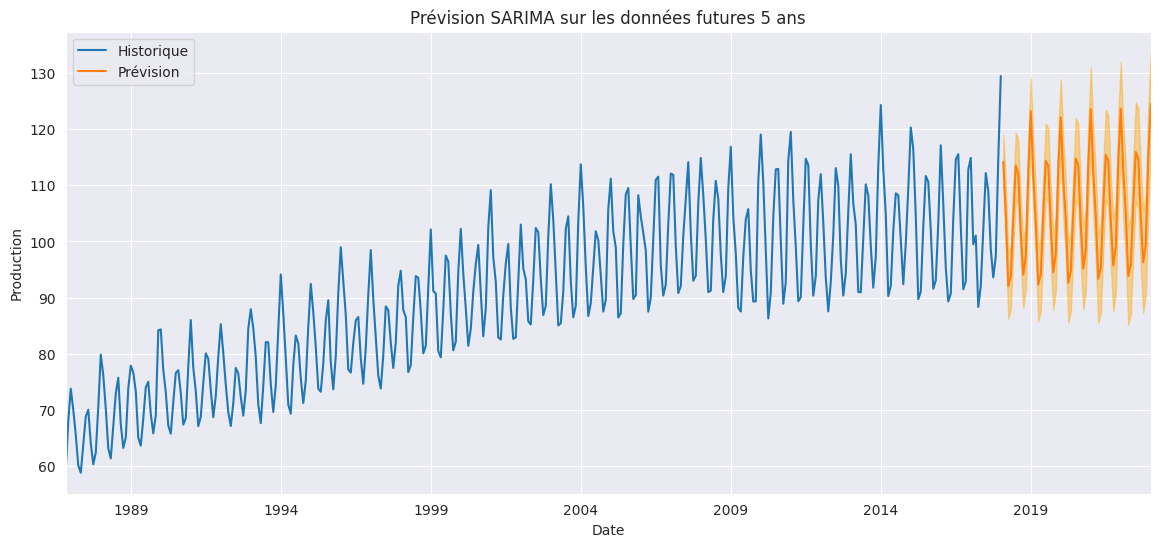

In [45]:
model = SARIMAX(df["IPG2211A2N"], 
                order=(1, 1, 2), 
                seasonal_order=(1, 1, 2, 12))
result = model.fit(maxiter=10000)

n_steps = 5*12 # Prédiction sur 5 ans dans le futur
forecast = result.get_forecast(
    steps=n_steps)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Visualisation
plt.figure(figsize=(14, 6))
df['IPG2211A2N'].plot(label='Historique')

# Afficher la prévision
mean_forecast.plot(label='Prévision')
plt.fill_between(conf_int.index, 
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1], 
                 color='orange', 
                 alpha=0.4 
                )

plt.legend()
plt.title(f'Prévision SARIMA sur les données futures {int(n_steps/12)} ans')
plt.xlabel('Date')
plt.ylabel('Production')
plt.show()

Etant donné la faible performance du modèle ARIMA, le résultat n'est pas concluant comme on pouvait s'en douter. Le modèle SARIMA semble vraisemblable, même sur des échelles de temps longues. Attention aux échelles de temps : plus l'estimation est faite sur un futur éloigné, plus la probabilité de se tromper est grande, ce qui se traduit par un intervalle de confiance énorme qui n'a plus de sens à partir d'un futur trop loin.

### 2.11 Déplooiement du modèle
---
#### 2.11.1 Sauvegarde du modèle

In [47]:
with open('sarima_model.pkl', 'wb') as f:
    pickle.dump(result, f)

#### 2.11.2 Chargement du modèle

In [48]:
with open('sarima_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

forecast = loaded_model.get_forecast(steps=12) # Prédiction avec le modèle chargé